#### **Import the required libraries**

We will be using a few libraries in this session, import all the required libraries in the cell below one by one as we go through the session.


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import yaml
from PIL import Image
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

#### **Download the dataset**

We will be using `CIFAR-10` dataset for this session. The dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Please download the dataset using the following command.

```python
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/knn_config.yaml
!unzip -q CIFAR-10.zip -d .
```


In [2]:
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
!wget https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/configs/knn_config.yaml
!unzip -q CIFAR-10.zip -d .

--2024-02-13 20:15:55--  https://github.com/ccdsiub/deeplearning-code-management/raw/1.1/CIFAR-10.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip [following]
--2024-02-13 20:15:55--  https://raw.githubusercontent.com/ccdsiub/deeplearning-code-management/1.1/CIFAR-10.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57166560 (55M) [application/zip]
Saving to: ‘CIFAR-10.zip’

CIFAR-10.zip        100%[===================>]  54.52M   209MB/s    in 0.3s    

2024-02-13 20:15:56 (209 MB/s) - ‘CIFAR-10.zip’ saved [57166560/57166560]

--2024-02

#### **Load configuration file**

We will be using a configuration file to store all the required parameters for the model. The configuration file is a YAML file, which is a human-readable data serialization standard that can be used in conjunction with all programming languages and is often used to write configuration files. Create a new file named `config.yaml` and add the following content to it.

```yaml
data_params:
  data_path: "CIFAR-10/"
```

Read the configuration file using the `yaml` library and store the data in a variable named `config`.


In [3]:
config = yaml.safe_load(open("knn_config.yaml"))
print(config)

{'data_params': {'data_path': 'CIFAR-10/', 'train_ratio': 0.8}, 'model_params': {'k': 5}}


#### **Load the dataset**

Check the files in the side panel to see if the dataset is downloaded successfully. The dataset is organized in the following way.

```
CIFAR-10
 |
 └───airplane
 |
 └───automobile
 |
 └───bird
 |
 └───cat
 |
 └───deer
 |
 └───dog
 |
 └───frog
 |
 └───horse
 |
 └───ship
 |
 └───truck
```

We will use basic python libraries like `os` and `numpy` to load the dataset. Create a function `load_data` to load the dataset. The function should take the path to the dataset as input and return a numpy array of images and labels. Following is the pseudo code for the function:

```python
def load_data(path, classes):
    # create empty lists to store images and labels

    # loop through the classes
        # create path to the class folder
        # loop through the images in the class folder
            # create the path to the image
            # read the image using PIL
            # convert the image to numpy array
            # append the image to the images list
            # append the class index to the labels list

    # return the images and labels as numpy arrays
```


In [4]:
def load_data(path: str, classes: list) -> tuple:
    """
    Load data from the given path and return the data and labels as numpy arrays.

    :param path: The path to the data.
    :type path: str
    :param classes: The classes in the data.
    :type classes: list

    :return: The data and labels.
    :rtype: tuple(np.array, np.array)
    """

    images = []
    labels = []
    for i, cls in enumerate(classes):
        class_path = os.path.join(path, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            img = np.array(img)
            images.append(img)
            labels.append(i)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

As the subfolder names are the class names, get the class names using `os.listdir` and save it to a variable `classes`. Use the `load_data` function to load the dataset and save the images and labels to variables `images` and `labels` respectively.


In [5]:
data_path = config["data_params"]["data_path"]
classes = os.listdir(data_path)
classes.sort()
print(classes)

images, labels = load_data(data_path, classes)
print(images.shape, labels.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(60000, 32, 32, 3) (60000,)


#### **Visualize the data**

Now, our dataset is loaded. Let's visualize the dataset using `matplotlib`. Choose a random image from the dataset and display the image along with the class name as the title. **Note:** In each run, the image should change, you can use `np.random.randint` to generate a random index.


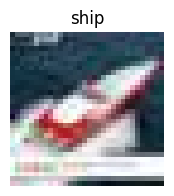

In [6]:
random_index = np.random.randint(0, len(images))

plt.figure(figsize=(2, 2))
plt.imshow(images[random_index])
plt.title(classes[labels[random_index]])
plt.axis('off')
plt.show()

#### **Preprocess the data**

We need to normalize the images before feeding them to the model. Normalization is a process that changes the range of pixel intensity values to a standard range, it helps the model to converge faster. To normalize the images, we will use the following steps:

1. Normalize to [0-1] by dividing each pixel by 255.
2. Subtract the ImageNet mean (0.485, 0.456, 0.406) and divide by the ImageNet standard deviation (0.229, 0.224, 0.225).

After normalization, we need to flatten the images. Use `np.reshape` to flatten the images.

Create a function `preprocess_data` to do the above steps. The function should take the images input and return the preprocessed images. Following is the pseudo code for the function:

```python
def preprocess_data(images):
    # normalize the images using ImageNet mean and standard deviation
    # flatten the images
    # return the preprocessed images
```


In [7]:
def preprocess_images(images: np.array) -> np.array:
    """
    Preprocess the images and labels.

    :param images: The images.
    :type images: np.array

    :return: The preprocessed images and labels.
    :rtype: tuple(np.array, np.array)
    """
    images = images / 255.0
    images = (images - np.array([0.485, 0.456, 0.406])
              ) / np.array([0.229, 0.224, 0.225])
    images = images.reshape(-1, 32*32*3)

    return images

Call the `preprocess_data` function to preprocess the images and save the preprocessed images to a variable `images`.


In [8]:
images = preprocess_images(images)
print(images.shape)

(60000, 3072)


#### **Split the data**

We need to split the data into training, testing, and validation sets. We will use `train_test_split` from `sklearn.model_selection` to split the data into training and testing sets. We will use 80% of the data for training and 20% for testing. Then, we will use `train_test_split` again to split the testing data into testing and validation sets. We will use 50% of the testing data for testing and 50% for validation.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels,
    test_size=(1-config["data_params"]["train_ratio"]),
    random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48000, 3072) (6000, 3072) (6000, 3072)
(48000,) (6000,) (6000,)


#### **Implement the K-Nearest Neighbor algorithm**

We will now implement the K-Nearest Neighbor algorithm from scratch. KNN algorithm uses a fixed number of training examples to predict the label of a new data point.

In our case, we will use the training images to predict the label of a new image. We will calculate the euclidean distance between the new image and all the training images. Then, we will find the K nearest neighbors of the new image. We will use the labels of the K nearest neighbors to predict the label of the new image. The predicted label will be the label that occurs the most number of times among the K nearest neighbors.

The whole process is explained in the following diagram:

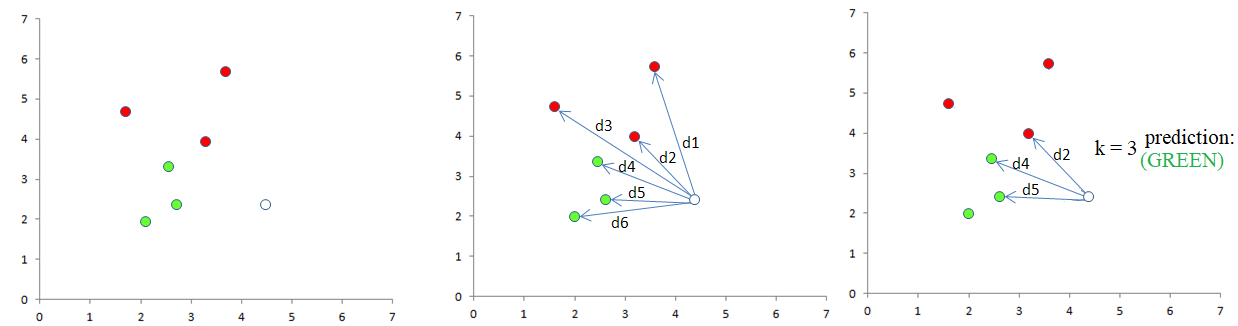

Now, follow the steps below to implement the KNN algorithm from scratch.


##### **Step 1: Calculate the euclidean distance**

Write a function named `euclidean_distance()` that takes two numpy arrays, `image` and `train_images` as input. `train_images` is a numpy array of images from the training set. The function should calculate the euclidean distance between the each image in the `train_images` array and the `image` array. The function should return a numpy array of euclidean distances. The euclidean distance between two images can be calculated using the following formula:

$$euclidean\_distance = \sqrt{(image\_1 - image\_2)^2}$$


In [10]:
def euclidean_distance(image: np.array, images: np.array) -> np.array:
    """
    Compute the euclidean distance between the image and the images.

    :param image: The image.
    :type image: np.array
    :param images: The images.
    :type images: np.array

    :return: The distances.
    :rtype: np.array
    """
    return np.sqrt(np.sum((images - image)**2, axis=1))

##### **Step 2: Find the nearest neighbor**

Now, we will find the nearest neighbor of a new image. Write a function named `nearest_neighbor()` that takes three inputs, `new_image`, `train_images`, and `train_labels`. The function should return the label of the nearest neighbor of the new image. The function should do the following:

- Calculate the euclidean distance between the new image and all the training images using the `euclidean_distance()` function and store the result in a numpy array named `distances`.
- Sort the `distances` array using `np.argsort()` and store the result in a numpy array named `sorted_indices`.
- Now, as `sorted_indices` contains the indices of the training images sorted by their distance from the new image, the first element of the `sorted_indices` array will contain the index of the training image that is closest to the new image. Store the label of the nearest neighbor in a variable named `nearest_neighbor`.
- Return the variable `nearest_neighbor`.

Call the `nearest_neighbor()` function to find the nearest neighbor of the first image in the testing set. Print the actual and predicted labels of the image.


In [11]:
def nearest_neighbor(
    new_image: np.array,
    train_images: np.array,
    train_labels: np.array
) -> int:
    """
    Compute the nearest neighbor of the image.

    :param new_image: The image.
    :type new_image: np.array
    :param train_images: The training images.
    :type train_images: np.array
    :param train_labels: The training labels.
    :type train_labels: np.array

    :return: The nearest neighbor.
    :rtype: int
    """
    distances = euclidean_distance(new_image, train_images)
    indices = np.argsort(distances)
    nearest_neighbor = train_labels[indices[0]]
    return nearest_neighbor


y_pred = nearest_neighbor(X_val[0], X_train, y_train)

print(f"Predicted: {classes[y_pred]}, True: {classes[y_val[0]]}")

Predicted: bird, True: deer


##### **Step 3: Find the K nearest neighbors**

The function we have defined is able to determine the nearest neighbour based on only watching one neighbour. We can extend this to find the K nearest neighbours. Where we will find the K nearest neighbours and then determine the most common label among them and return that as the predicted label.

Update the `nearest_neighbor()` function in such a way that it takes an additional input, `k`. The function should return the label of the K nearest neighbors of the new image. Rename the function to `k_nearest_neighbors()`. You have to do the following:

- Change the function name to `k_nearest_neighbors()`.
- Add an extra parameter named `k` to the function definition. k is the number of nearest neighbors to find.
- Update the line number 4 of the function and get the labels for the first `k` elements of the `indices` array. Rename the variable `nearest_neighbor` to `nearest_neighbors`.
- Use the `np.unique()` function to find the unique labels and their counts in the `nearest_neighbors` array. Store the result in a variables named `values` and `counts` respectively.
- Use the `np.argmax()` function to find the index of the most common label in the `counts` array. Use the index to get the most common label from the `values` array. Store the most common label in a variable named `predicted_label`.
- Return the variable `predicted_label`.

Call the `k_nearest_neighbors()` function to find the K nearest neighbors of the first image in the testing set. Print the actual and predicted labels of the image.


In [12]:
def k_nearest_neighbor(
    new_image: np.array,
    train_images: np.array,
    train_labels: np.array, k: int
) -> int:
    """
    Compute the k nearest neighbors of the image.

    :param new_image: The image.
    :type new_image: np.array
    :param train_images: The training images.
    :type train_images: np.array
    :param train_labels: The training labels.
    :type train_labels: np.array
    :param k: The number of nearest neighbors.

    :return: The predicted label.
    :rtype: int
    """
    distances = euclidean_distance(new_image, train_images)
    indices = np.argsort(distances)
    nearest_neighbors = train_labels[indices[:k]]

    values, counts = np.unique(nearest_neighbors, return_counts=True)
    predicted_label = values[np.argmax(counts)]

    return predicted_label


predicted_label = k_nearest_neighbor(
    X_val[0], X_train, y_train, k=config["model_params"]["k"])

print(f"Predicted: {classes[predicted_label]}, True: {classes[y_val[0]]}")

Predicted: bird, True: deer


#### **Step 4: Predict the labels of the testing images**

Now, we will use the `k_nearest_neighbors()` function to predict the labels of all the testing images. Write a function named `predict()` that takes three inputs, `test_images`, `train_images`, and `train_labels`. The function should return a numpy array of predicted labels. The function should do the following:

- Create an empty numpy array named `predicted_labels`.
- Loop through all the images in the `test_images` array. For each image, call the `k_nearest_neighbors()` function to find the K nearest neighbors of the image. Append the predicted label to the `predicted_labels` array.
- Return the `predicted_labels` array.

Call the `predict()` function to predict the labels of the testing images and store the result in a variable named `predicted_labels`. Print the actual and predicted labels of the first 10 images in the testing set.


In [13]:
def predict(test_images, train_images, train_labels, k):
    predictions = np.array([])

    for i, image in enumerate(
            tqdm.tqdm(test_images, ncols=100, desc="Predicting")):
        predicted_label = k_nearest_neighbor(
            image, train_images, train_labels, k)
        predictions = np.append(predictions, predicted_label)
    return predictions


y_pred = predict(X_test, X_train, y_train, k=config["model_params"]["k"])

print("\nPredictiosn: ", y_pred[:10])
print("True: ", y_test[:10])

Predicting: 100%|█████████████████████████████████████████████| 6000/6000 [1:24:31<00:00,  1.18it/s]


Predictiosn:  [0. 0. 0. 8. 8. 2. 8. 0. 0. 4.]
True:  [9 0 1 9 9 5 8 8 3 4]


#### **Evaluate model performance**

Now, we will evaluate the performance of the KNN algorithm.

1. Use scikit-learn's `classification_report` function to evaluate the performance of the model. The `classification_report` function takes two inputs, `test_labels` and `predicted_labels`, and returns a report of the precision, recall, and F1-score of the model.
2. Use the `confusion_matrix` function to get the confusion matrix of the model. It also takes two inputs, `test_labels` and `predicted_labels`, and returns the confusion matrix of the model. Use `ConfusionMatrixDisplay` to display the confusion matrix.


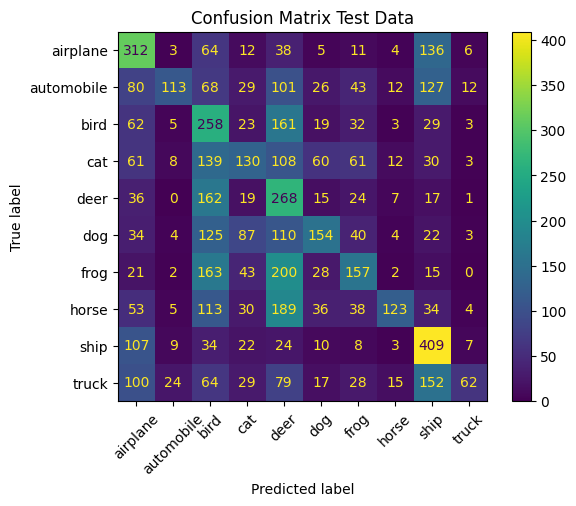




              precision    recall  f1-score   support

    airplane       0.36      0.53      0.43       591
  automobile       0.65      0.18      0.29       611
        bird       0.22      0.43      0.29       595
         cat       0.31      0.21      0.25       612
        deer       0.21      0.49      0.29       549
         dog       0.42      0.26      0.32       583
        frog       0.36      0.25      0.29       631
       horse       0.66      0.20      0.30       625
        ship       0.42      0.65      0.51       633
       truck       0.61      0.11      0.18       570

    accuracy                           0.33      6000
   macro avg       0.42      0.33      0.32      6000
weighted avg       0.42      0.33      0.32      6000



In [14]:
# bottom level to a slight tilted

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
    y_test, y_pred), display_labels=classes)
disp = disp.plot(xticks_rotation=45)
plt.title('Confusion Matrix Test Data')
plt.show()

print('\n\n')
print(classification_report(y_test, y_pred, target_names=classes))

#### **Put it all together**

Now, put all the code together in a class named `KNNClassifier`. The class should have the following methods:

- `data_loader()`: Load the dataset and split it into training and testing sets.
- `euclidean_distance()`: Calculate the euclidean distance between the new image and all the training images.
- `k_nearest_neighbors()`: Find the K nearest neighbors of the new image.
- `fit()`: Train the model.
- `predict()`: Predict the labels of the testing images.
- `evaluate()`: Evaluate the performance of the model.


In [ ]:
class KNNClassifier:
    """
    K-Nearest Neighbor classifier.
    """

    def __init__(self, k: int, data_path: str) -> None:
        """
        Initialize the KNNClassifier.

        :param k: The number of nearest neighbors.
        :type k: int
        :param data_path: The path to the data.
        :type data_path: str
        """
        self.k = k
        self.data_path = data_path
        self.classes = os.listdir(data_path)
        self.classes.sort()

    def load_data(self) -> None:
        """
        Load the data.
        """
        images = []
        labels = []
        for i, cls in enumerate(self.classes):
            class_path = os.path.join(self.data_path, cls)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                img = np.array(img)
                images.append(img)
                labels.append(i)

        images = np.array(images)
        labels = np.array(labels)

        self.images = images
        self.labels = labels

    def preprocess_data(self) -> None:
        """
        Preprocess the data.
        """
        images = self.images / 255.0
        images = (images - np.array([0.485, 0.456, 0.406])
                  ) / np.array([0.229, 0.224, 0.225])
        images = images.reshape(-1, 32*32*3)

        self.images = images

    def data_loader(self, train_ratio: float = 0.9) -> None:
        """
        Split the data into training, validation, and testing sets.

        :param train_ratio: The ratio of the training data.
        :type train_ratio: float
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.images, self.labels,
            test_size=(1-train_ratio),
            random_state=42, shuffle=True)
        self.X_test, self.X_val, self.y_test, self.y_val = train_test_split(
            self.X_test, self.y_test, test_size=0.5,
            random_state=42, shuffle=True)

    def euclidean_distance(self, image: np.array, images: np.array) -> np.array:
        """
        Compute the euclidean distance between the image and the images.

        :param image: The image.
        :type image: np.array
        :param images: The images.
        :type images: np.array

        :return: The distances.
        :rtype: np.array
        """
        return np.sqrt(np.sum((images - image)**2, axis=1))

    def k_nearest_neighbor(
        self,
        new_image: np.array,
        train_images: np.array,
        train_labels: np.array
    ) -> int:
        """
        Compute the k nearest neighbors of the image.

        :param new_image: The image.
        :type new_image: np.array
        :param train_images: The training images.
        :type train_images: np.array
        :param train_labels: The training labels.
        :type train_labels: np.array

        :return: The predicted label.
        :rtype: int
        """
        distances = self.euclidean_distance(new_image, train_images)
        indices = np.argsort(distances)
        nearest_neighbors = train_labels[indices[:self.k]]

        values, counts = np.unique(nearest_neighbors, return_counts=True)
        predicted_label = values[np.argmax(counts)]

        return predicted_label

    def train(self, train_ratio: float = 0.9) -> None:
        """
        Train the model.

        :param train_ratio: The ratio of the training data.
        :type train_ratio: float
        """
        self.load_data()
        self.preprocess_data()
        self.data_loader(train_ratio)

    def predict(self, test_images: np.array) -> np.array:
        """
        Predict the labels of the test images.

        :param test_images: The test images.
        :type test_images: np.array

        :return: The predicted labels.
        :rtype: np.array
        """
        predictions = np.array([])

        for i, image in enumerate(
                tqdm.tqdm(test_images, ncols=100, desc="Predicting")):
            predicted_label = self.k_nearest_neighbor(
                image, self.X_train, self.y_train)
            predictions = np.append(predictions, predicted_label)
        return predictions

    def evaluate(self, y_pred: np.array) -> None:
        """
        Evaluate the model.

        :param y_pred: The predicted labels.
        :type y_pred: np.array
        """
        print(classification_report(self.y_test,
              y_pred, target_names=self.classes))
        print('\n\n')
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(
            self.y_test, y_pred), display_labels=self.classes)
        disp = disp.plot(xticks_rotation=45)
        plt.title('Confusion Matrix Test Data')
        plt.show()


knn = KNNClassifier(k=config["model_params"]["k"],
                    data_path=config["data_params"]["data_path"])

knn.train(train_ratio=config["data_params"]["train_ratio"])
y_pred = knn.predict(knn.X_test)
knn.evaluate(y_pred)